In [1]:
from string import Template
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timezone
import datetime
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
from matplotlib.animation import FuncAnimation
from copy import deepcopy
from sklearn.metrics import r2_score
from google.colab import files
from keras.layers import *
from keras.layers.recurrent import LSTM
from keras.models import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd /content/drive/MyDrive/KHDL

/content/drive/MyDrive/KHDL


# **Part 1: Getting Bitcoin Price Hourly**

##### **Declare Variables and Functions**

In [6]:
# format: Local time: yyyy-mm-dd hh:mm:ss
# Default: 2021-01-01 00:00:00 -> utcnow
datetimeBegin = '2021-01-01 00:00:00'
datetimeEnd = datetime.datetime.utcnow()

listCoinID = {'Bitcoin': 1, 'Ethereum': 1027, 'BinanceCoin': 1839, 'Maker': 1518, 'Litecoin': 2}

In [37]:
# Get localtime from timestamp
def getLocalTimeFromTimestamp(timestamp):
    return datetime.datetime.fromtimestamp(timestamp + 7*3600)


def getUTCTimeFromTimestamp(timestamp):
    return datetime.datetime.fromtimestamp(timestamp)


# Change format localtime
def changeFormatLocaltime(localtime):
    return datetime.datetime.strftime(localtime, '%d %b %Y, %H:%M')

# Get UCT timestamp from localtime
def getUTCTimestampFromTime(localDatetime):
    try:
        localDatetime = datetime.datetime.strptime(localDatetime, '%Y-%m-%d %H:%M:%S')
        return int(localDatetime.replace(tzinfo=timezone.utc).timestamp())
    except:
        return int(localDatetime.replace(tzinfo=timezone.utc).timestamp())

# Get Coin Price Hourly
def getCoinPriceHourly(coinName, datetimeBegin=datetimeBegin, datetimeEnd=datetime.datetime.utcnow(), numOfSamples=1000):
    # Get Coin ID -> if not exist, return Error Message
    try:
      coinID = listCoinID[coinName]
    except:
      return 'Coin is not exist!'
    
    # Get Timestamp from UTCTime
    timestampBegin = str(getUTCTimestampFromTime(datetimeBegin))
    timestampEnd = str(getUTCTimestampFromTime(datetimeEnd))

    # Get URL Coin price hourly
    website = Template(
        'https://api.coinmarketcap.com/data-api/v3/cryptocurrency/historical?id=$coinID&convertId=2781&timeStart=$timestampBegin&timeEnd=$timestampEnd')
    url_API = website.substitute(coinID=coinID, timestampBegin=timestampBegin,
                                 timestampEnd=timestampEnd)
    # Create DataFrame to save Data
    details = ['Timestamp', 'Localtime', 'Price', 'Volume1h', 'MarketCap']
    df = pd.DataFrame(columns=details)
    # Get Data from URL
    print(url_API)
    json = requests.get(url_API).json()['data']
    numOfCrawledData = len(json)
    sample = 0
    keys = list(json.keys())[-numOfSamples:]
    print(keys)
    while sample < numOfSamples and sample < numOfCrawledData:
        utc = keys[sample]
        print(utc)
        utc = utc.replace('T', ' ')
        utc = utc.replace('.000Z', '')
        timestamp = getUTCTimestampFromTime(utc)
        df = df.append({df.columns[0]: timestamp,
                        df.columns[1]: getLocalTimeFromTimestamp(timestamp),
                        df.columns[2]: json[keys[sample]]['USD'][0],
                        df.columns[3]: json[keys[sample]]['USD'][1],
                        df.columns[4]: json[keys[sample]]['USD'][2]},
                       ignore_index=True)
        sample += 1
    return df

##### **Get Crypto Price Hourly and Save as .csv file**

In [39]:
csvBitcoin = './BitcoinPriceHourly.csv'
csvEthereum = './EthereumPriceHourly.csv'
csvBinanceCoin = './BinanceCoinPriceHourly.csv'
csvMaker = './MakerPriceHourly.csv'
csvLitecoin = './LitecoinPriceHourly.csv'

dfBitcoin = pd.read_csv(csvBitcoin)
dfEthereum = pd.read_csv(csvEthereum)
dfBinanceCoin = pd.read_csv(csvBinanceCoin)
dfMaker = pd.read_csv(csvMaker)
dfLitecoin = pd.read_csv(csvLitecoin)

In [ ]:
csvBitcoin = './BitcoinPriceHourly.csv'
csvEthereum = './EthereumPriceHourly.csv'
csvBinanceCoin = './BinanceCoinPriceHourly.csv'
csvMaker = './MakerPriceHourly.csv'
csvLitecoin = './LitecoinPriceHourly.csv'

numOfSamples = 1000
datetimeEnd = '2022-03-03 00:00:00'

dfBitcoin = getCoinPriceHourly('Bitcoin', datetimeEnd=datetimeEnd, numOfSamples=numOfSamples)
dfBitcoin.to_csv(csvBitcoin, index=False)
dfEthereum = getCoinPriceHourly('Ethereum', datetimeEnd=datetimeEnd, numOfSamples=numOfSamples)
dfEthereum.to_csv(csvEthereum, index=False)
dfBinanceCoin = getCoinPriceHourly('BinanceCoin', datetimeEnd=datetimeEnd, numOfSamples=numOfSamples)
dfBinanceCoin.to_csv(csvBinanceCoin, index=False)
dfMaker = getCoinPriceHourly('Maker', datetimeEnd=datetimeEnd, numOfSamples=numOfSamples)
dfMaker.to_csv(csvMaker, index=False)
dfLitecoin = getCoinPriceHourly('Litecoin', datetimeEnd=datetimeEnd, numOfSamples=numOfSamples)
dfLitecoin.to_csv(csvLitecoin, index=False)

In [ ]:
dfBitcoin

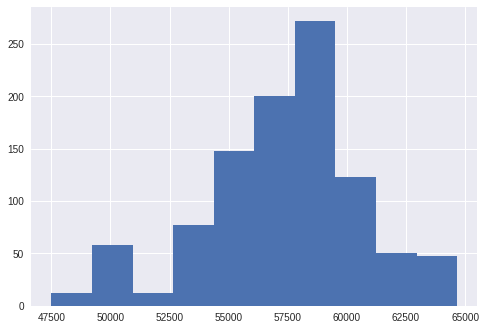

In [43]:
dfBitcoin.Price.hist()

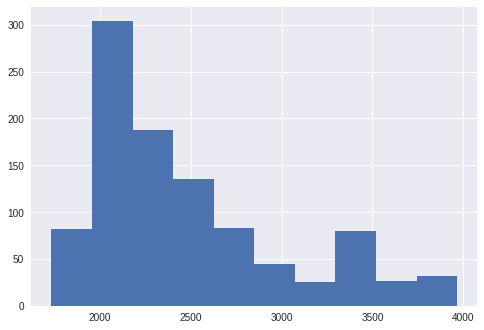

In [44]:
dfEthereum.Price.hist()

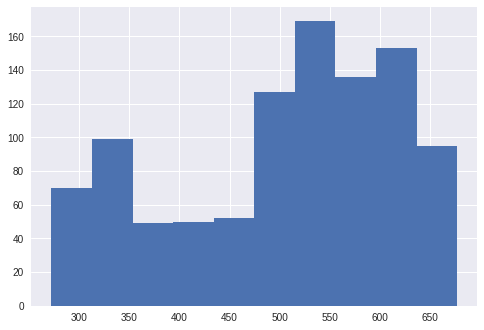

In [45]:
dfBinanceCoin.Price.hist()

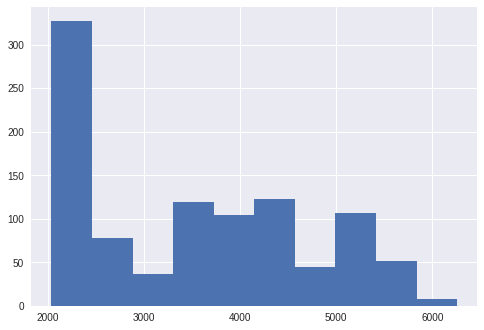

In [42]:
dfMaker.Price.hist()

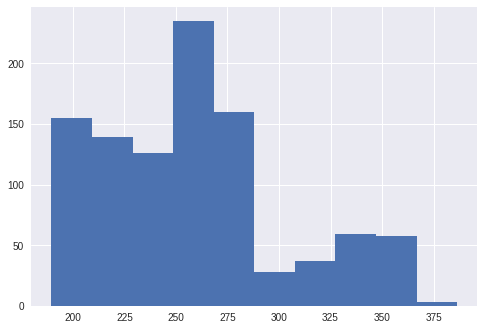

In [46]:
dfLitecoin.Price.hist()

##### **Plot Data**

In [40]:
def plotData(df):
  plt.style.use('seaborn')
  fig, ax = plt.subplots(1, 2, figsize=(18, 5))
  ax[0].plot('Localtime', 'Price', data=df)
  ax[0].set_title('Price Hourly (USD)')
  ax[0].set(xlabel='Time', ylabel='Price (USD)')
  ax[0].xaxis.set_major_formatter(mpl_dates.DateFormatter('%d %b %Y'))
  fig.autofmt_xdate()
  ax[1].plot('Localtime', 'Volume1h', data=df)
  ax[1].set_title('Volume1h Hourly (USD)')
  ax[1].set(xlabel='Time', ylabel='Volume1h (USD)')
  ax[1].xaxis.set_major_formatter(mpl_dates.DateFormatter('%d %b %Y'))
  fig.autofmt_xdate()
  plt.show()
  fig, ax = plt.subplots(1, 2, figsize=(18, 5))
  ax[0].plot('Localtime', 'MarketCap', data=df)
  ax[0].set_title('MarketCap Hourly (USD)')
  ax[0].set(xlabel='Time', ylabel='MarketCap (USD)')
  ax[0].xaxis.set_major_formatter(mpl_dates.DateFormatter('%d %b %Y'))
  fig.autofmt_xdate()
  plt.show()

In [ ]:
plotData(dfBitcoin)

In [ ]:
plotData(dfEthereum)

In [ ]:
plotData(dfBinanceCoin)

In [ ]:
plotData(dfMaker)

In [ ]:
plotData(dfLitecoin)

In [ ]:
dfBitcoin.describe()

# **Part 2: Preprocessing Data**

In [47]:
dfBitcoin.isnull().sum()

Timestamp    0
Localtime    0
Price        0
Volume1h     0
MarketCap    0
dtype: int64

##### **Feature Extraction**

In [48]:
Bitcoin_X = np.asarray(dfBitcoin[['Volume1h', 'MarketCap']])
Bitcoin_Y = np.asarray(dfBitcoin['Price'])
Bitcoin_Y = Bitcoin_Y.reshape(len(Bitcoin_Y), 1)

Ethereum_X = np.asarray(dfEthereum[['Volume1h', 'MarketCap']])
Ethereum_Y = np.asarray(dfEthereum['Price'])
Ethereum_Y = Ethereum_Y.reshape(len(Ethereum_Y), 1)

BinanceCoin_X = np.asarray(dfBinanceCoin[['Volume1h', 'MarketCap']])
BinanceCoin_Y = np.asarray(dfBinanceCoin['Price'])
BinanceCoin_Y = BinanceCoin_Y.reshape(len(BinanceCoin_Y), 1)

Maker_X = np.asarray(dfMaker[['Volume1h', 'MarketCap']])
Maker_Y = np.asarray(dfMaker['Price'])
Maker_Y = Maker_Y.reshape(len(Maker_Y), 1)

Litecoin_X = np.asarray(dfLitecoin[['Volume1h', 'MarketCap']])
Litecoin_Y = np.asarray(dfLitecoin['Price'])
Litecoin_Y = Litecoin_Y.reshape(len(Litecoin_Y), 1)

# **Part 3: Machine Learning**

In [49]:
trainSize = 800

BTC_xtrain, BTC_xtest = Bitcoin_X[0 : trainSize], Bitcoin_X[trainSize :]
BTC_ytrain, BTC_ytest = Bitcoin_Y[0 : trainSize], Bitcoin_Y[trainSize :]

ETH_xtrain, ETH_xtest = Ethereum_X[0 : trainSize], Ethereum_X[trainSize :]
ETH_ytrain, ETH_ytest = Ethereum_Y[0 : trainSize], Ethereum_Y[trainSize :]

BNB_xtrain, BNB_xtest = BinanceCoin_X[0 : trainSize], BinanceCoin_X[trainSize :]
BNB_ytrain, BNB_ytest = BinanceCoin_Y[0 : trainSize], BinanceCoin_Y[trainSize :]

MKR_xtrain, MKR_xtest = Maker_X[0 : trainSize], Maker_X[trainSize :]
MKR_ytrain, MKR_ytest = Maker_Y[0 : trainSize], Maker_Y[trainSize :]

LTC_xtrain, LTC_xtest = Litecoin_X[0 : trainSize], Litecoin_X[trainSize :]
LTC_ytrain, LTC_ytest = Litecoin_Y[0 : trainSize], Litecoin_Y[trainSize :]

##### **Linear Regression**

In [50]:
class LinearRegression:
  def __init__(self, coin = 'Unknown'):
    self.min_x = []
    self.max_x = []
    self.min_y = 0
    self.max_y = 0
    self.thetas = []
    self.losses = []
    self.accuracy = []
    self.coin = coin

  def normalize(self, data):
    data_norm = deepcopy(data)
    try:
        columnCount = len(data_norm[0])
        for column in range(columnCount):
            data_norm[:, column] = (data_norm[:, column] - np.min(data_norm[:, column]))/(np.max(data_norm[:, column]) - np.min(data_norm[:, column]))
        return data_norm
    except:
        data_norm = (data_norm - np.min(data_norm))/(np.max(data_norm) - np.min(data_norm))
        return data_norm

  def fit(self, x, y, learning_rate = 0.01, n_iterations = 2000):
    # khởi tạo giá trị tham số
    for i in range(len(x[0])):
      self.min_x.append(np.min(x[:, i]))
      self.max_x.append(np.max(x[:, i]))
    self.min_y = np.min(y)
    self.max_y = np.max(y)
    x_norm = self.normalize(x)
    y_norm = self.normalize(y)

    x_expand = np.c_[np.ones((len(x_norm), 1)), x_norm]
    n = len(x_expand)

    theta = np.random.randn(len(x_expand[0]), 1)
    for i in range(len(x_expand[0])):
      theta[i] = np.median(x_expand[:, i])
    for i in range(n_iterations):
        # tính output
        output = x_expand.dot(theta) #ouput = sigmoid(x_expand.dot(theta))

        # tính loss
        loss = (output - y_norm)**2  

        # tính đạo hàm cho loss
        loss_grd = 2*(output - y_norm)/n

        # tính đạo hàm cho các tham số
        gradients = x_expand.T.dot(loss_grd)

        # cập nhật tham số
        theta = theta - learning_rate*gradients
        
        mean_loss = np.sum(loss)/n
        self.losses.append(mean_loss)

        #r2_score
        score = 1 - (np.sum(((y_norm - output)**2))/np.sum((y_norm - np.mean(y_norm))**2))
        if score > 0:
          self.accuracy.append(score)
        
    self.thetas = theta

  def predict(self, x):
    y_pred = []
    x_input = deepcopy(x)
    for i in range(len(x_input)):
      for j in range(len(x_input[i])):
        x_input[i][j] =  (x_input[i][j] - self.min_x[j]) / (self.max_x[j] - self.min_x[j])
      y = x_input[i].dot(self.thetas[1:]) + self.thetas[0]
      y_pred.append(y*(self.max_y - self.min_y) + self.min_y)
    return y_pred

  def plotLossAndAccuracy(self, saved = False):
    if len(self.losses) == 0:
      print('Model must be fitted first')
      return
    plt.style.use('seaborn')
    plt.figure(figsize = (15, 4))
    plt.subplot(121)
    plt.plot(range(len(self.losses)), self.losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('{} Loss'.format(self.coin))
    plt.subplot(122)
    plt.plot(range(len(self.accuracy)), self.accuracy)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('{} Accuracy'.format(self.coin)) 
    if saved:
      plt.savefig('./Images/{} LR Loss & Accuracy.png'.format(self.coin))
      files.download('./Images/{} LR Loss & Accuracy.png'.format(self.coin)) 

In [51]:
linearRegression_BTC = LinearRegression('Bitcoin')
linearRegression_BTC.fit(BTC_xtrain, BTC_ytrain)
linearRegression_ETH = LinearRegression('Ethereum')
linearRegression_ETH.fit(ETH_xtrain, ETH_ytrain)
linearRegression_BNB = LinearRegression('BinanceCoin')
linearRegression_BNB.fit(BNB_xtrain, BNB_ytrain)
linearRegression_MKR = LinearRegression('Maker')
linearRegression_MKR.fit(MKR_xtrain, MKR_ytrain)
linearRegression_LTC = LinearRegression('Litecoin')
linearRegression_LTC.fit(LTC_xtrain, LTC_ytrain)

Bitcoin_Pred = linearRegression_BTC.predict(BTC_xtest)
Ethereum_Pred = linearRegression_ETH.predict(ETH_xtest)
BinanceCoin_Pred = linearRegression_BNB.predict(BNB_xtest)
Maker_Pred = linearRegression_MKR.predict(MKR_xtest)
Litecoin_Pred = linearRegression_LTC.predict(LTC_xtest)

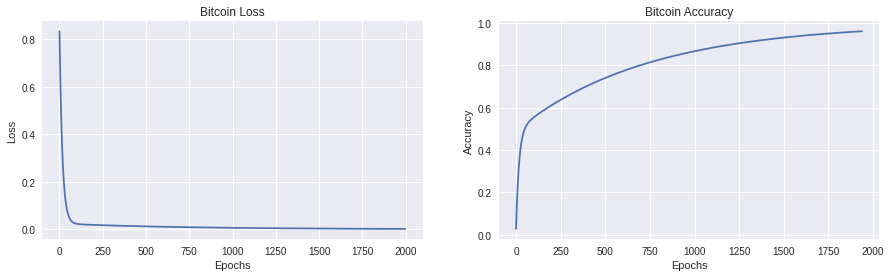

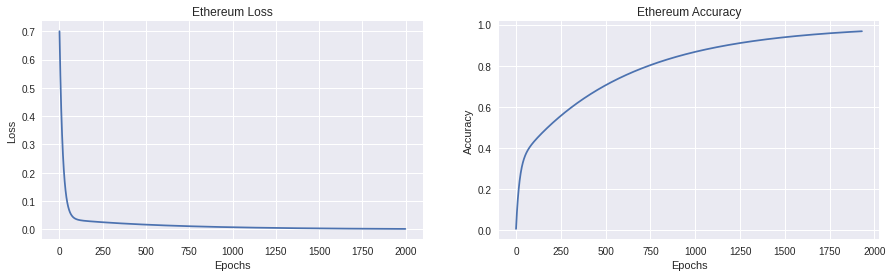

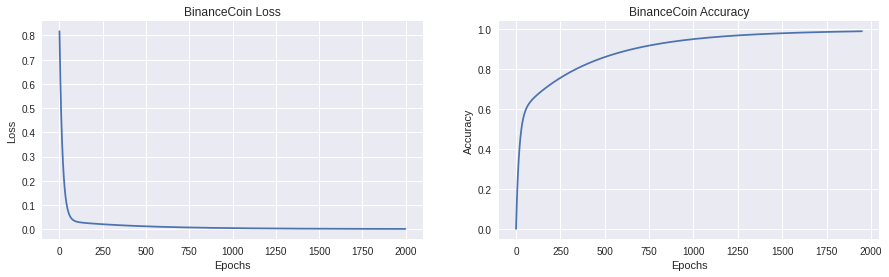

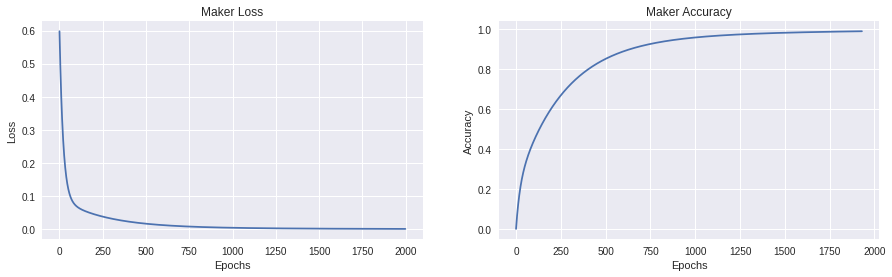

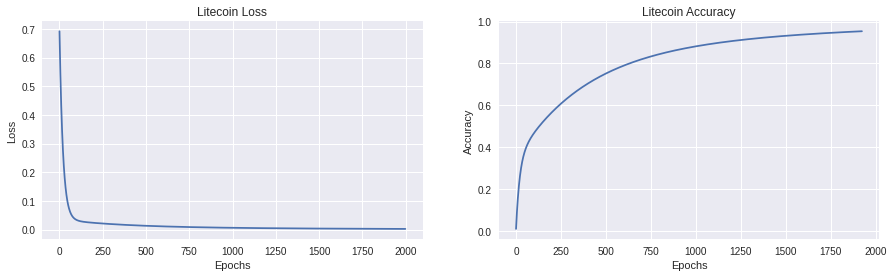

In [52]:
linearRegression_BTC.plotLossAndAccuracy()
linearRegression_ETH.plotLossAndAccuracy()
linearRegression_BNB.plotLossAndAccuracy()
linearRegression_MKR.plotLossAndAccuracy()
linearRegression_LTC.plotLossAndAccuracy()

In [53]:
def plotPredictAndRealValue(real, predict, coin = 'Unknown', saved = False, model = 'LR'):
  plt.figure(figsize = (10, 5))
  plt.plot(range(1000 - len(predict), 1000), predict, 'r')
  plt.plot(range(len(real)), real, 'b')
  plt.legend(['Prediction value', 'Real Value'])
  plt.xlabel('Sample')
  plt.ylabel('Price')
  plt.title('{} {}'.format(coin, model))
  if saved:
    plt.savefig('./Images/{} {} Predict & Real value.png'.format(coin, model))
    files.download('./Images/{} {} Predict & Real value.png'.format(coin, model)) 

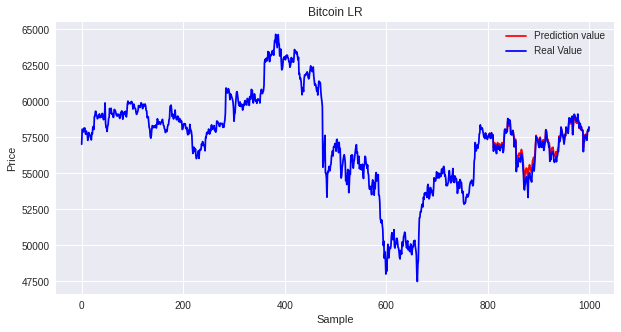

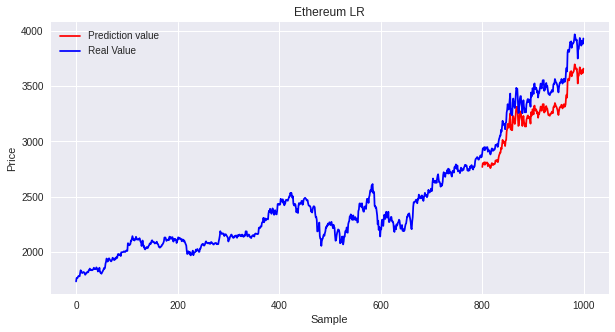

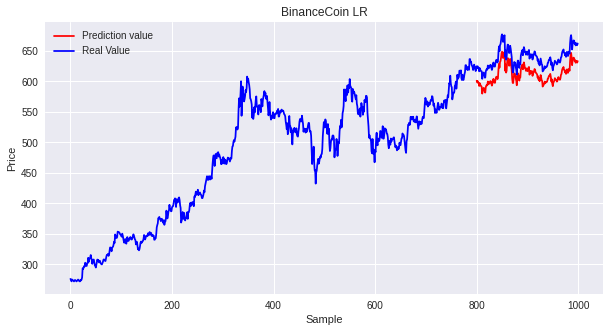

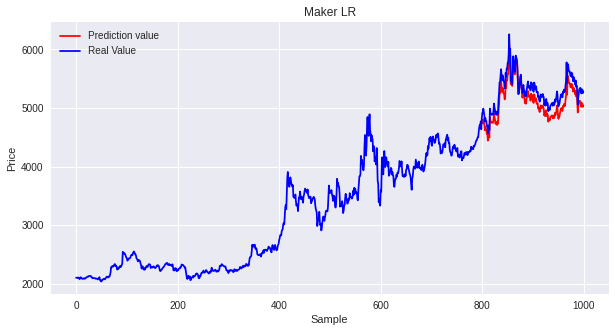

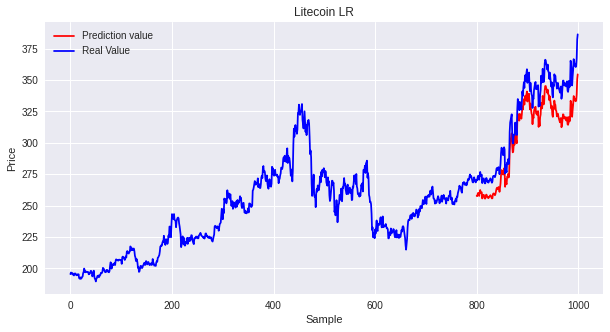

In [54]:
plotPredictAndRealValue(Bitcoin_Y, Bitcoin_Pred, 'Bitcoin', False)
plotPredictAndRealValue(Ethereum_Y, Ethereum_Pred, 'Ethereum', False)
plotPredictAndRealValue(BinanceCoin_Y, BinanceCoin_Pred, 'BinanceCoin', False)
plotPredictAndRealValue(Maker_Y, Maker_Pred, 'Maker', False)
plotPredictAndRealValue(Litecoin_Y, Litecoin_Pred, 'Litecoin', False)

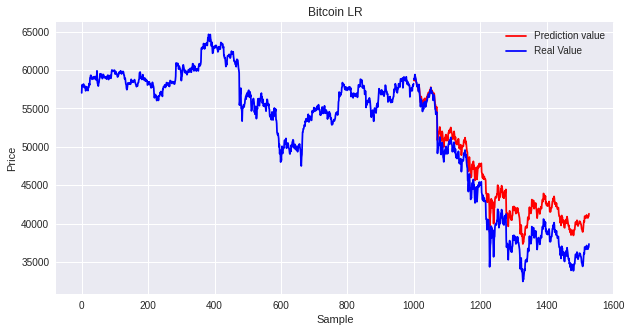

In [ ]:
dfBitcoin_Future = getCoinPriceHourly('Bitcoin', datetimeBegin='2021-05-10 00:00:00', datetimeEnd='2021-06-01 00:00:00', numOfSamples=numOfSamples)
Bitcoin_X_Future = np.asarray(dfBitcoin_Future[['Volume1h', 'MarketCap']])
Bitcoin_Y_Future = np.asarray(dfBitcoin_Future[['Price']])
Bitcoin_Pred_Future = linearRegression_BTC.predict(Bitcoin_X_Future)

numOfSamples = 1000
plt.figure(figsize = (10, 5))
plt.plot(range(numOfSamples, numOfSamples + len(Bitcoin_Pred_Future)), Bitcoin_Pred_Future, 'r')
plt.plot(range(numOfSamples, numOfSamples + len(dfBitcoin_Future)), dfBitcoin_Future['Price'], 'b')
plt.plot(range(len(Bitcoin_Y)), Bitcoin_Y, 'b')
plt.legend(['Prediction value', 'Real Value'])
plt.xlabel('Sample')
plt.ylabel('Price')
plt.title('{} {}'.format('Bitcoin', 'LR'))
# plt.savefig('./Images/Bitcoin Future Predict & Real value.png')
# files.download('./Images/Bitcoin Future Predict & Real value.png') 
plt.show()

##### **Long Short Term Memory**

In [ ]:
class LSTM_:
  def __init__(self, coin = 'Unknown'):
    self.min_x = []
    self.max_x = []
    self.min_y = 0
    self.max_y = 0
    self.losses = []
    self.coin = coin
    model = Sequential()
    model.add(LSTM(20, return_sequences = True, input_shape = (2 , 1)))
    model.add(LSTM(20, return_sequences = False))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = 'rmsprop')
    self.model = model

  def normalize(self, data):
    data_norm = deepcopy(data)
    try:
        columnCount = len(data_norm[0])
        for column in range(columnCount):
            data_norm[:, column] = (data_norm[:, column] - np.min(data_norm[:, column]))/(np.max(data_norm[:, column]) - np.min(data_norm[:, column]))
        return data_norm
    except:
        data_norm = (data_norm - np.min(data_norm))/(np.max(data_norm) - np.min(data_norm))
        return data_norm

  def fit(self, x, y, num_epoch = 10):
    for i in range(len(x[0])):
      self.min_x.append(np.min(x[:, i]))
      self.max_x.append(np.max(x[:, i]))
    self.min_y = np.min(y)
    self.max_y = np.max(y)
    x_norm = self.normalize(x)
    y_norm = self.normalize(y)
    x_norm = x_norm.reshape(x_norm.shape[0], x_norm.shape[1], 1)
    self.losses = self.model.fit(x_norm, y_norm, 5, epochs = num_epoch)
    self.losses = self.losses.history['loss']

  def predict(self, x):
    y_pred = []
    x_input = deepcopy(x)
    for i in range(len(x_input)):
      for j in range(len(x_input[i])):
        x_input[i][j] =  (x_input[i][j] - self.min_x[j]) / (self.max_x[j] - self.min_x[j])
      y = self.model.predict(x_input[i].reshape(1, x_input[i].shape[0], 1))
      y_pred.append(y*(self.max_y - self.min_y) + self.min_y)
    return np.asarray(y_pred).reshape(len(x_input), 1)

  def plotLoss(self, saved = False):
    if len(self.losses) == 0:
      print('Model must be fitted first')
      return
    plt.style.use('seaborn')
    plt.figure(figsize = (10, 5))
    plt.plot(range(len(self.losses)), self.losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('{} LSTM Loss'.format(self.coin))
    if saved:
      plt.savefig('./Images/{} LSTM Loss.png'.format(self.coin))
      files.download('./Images/{} LSTM Loss.png'.format(self.coin)) 
    plt.show()

In [ ]:
LSTM_BTC = LSTM_('Bitcoin')
LSTM_BTC.fit(BTC_xtrain, BTC_ytrain)
LSTM_ETH = LSTM_('Ethereum')
LSTM_ETH.fit(ETH_xtrain, ETH_ytrain)
LSTM_BNB = LSTM_('BinanceCoin')
LSTM_BNB.fit(BNB_xtrain, BNB_ytrain)
LSTM_MKR = LSTM_('Maker')
LSTM_MKR.fit(MKR_xtrain, MKR_ytrain)
LSTM_LTC = LSTM_('Litecoin')
LSTM_LTC.fit(LTC_xtrain, LTC_ytrain)

Bitcoin_Pred_LSTM = LSTM_BTC.predict(BTC_xtest)
Ethereum_Pred_LSTM = LSTM_ETH.predict(ETH_xtest)
BinanceCoin_Pred_LSTM = LSTM_BNB.predict(BNB_xtest)
Maker_Pred_LSTM = LSTM_MKR.predict(MKR_xtest)
Litecoin_Pred_LSTM = LSTM_LTC.predict(LTC_xtest)

Epoch 1/10
160/160 [==============================] - 27s 4ms/step - loss: 0.1604
Epoch 2/10
160/160 [==============================] - 1s 4ms/step - loss: 0.0343
Epoch 3/10
160/160 [==============================] - 1s 4ms/step - loss: 0.0275
Epoch 4/10
160/160 [==============================] - 1s 4ms/step - loss: 0.0137
Epoch 5/10
160/160 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 6/10
160/160 [==============================] - 1s 4ms/step - loss: 7.5838e-04
Epoch 7/10
160/160 [==============================] - 1s 4ms/step - loss: 6.7995e-04
Epoch 8/10
160/160 [==============================] - 1s 4ms/step - loss: 5.1811e-04
Epoch 9/10
160/160 [==============================] - 1s 4ms/step - loss: 4.7445e-04
Epoch 10/10
160/160 [==============================] - 1s 4ms/step - loss: 3.6144e-04
Epoch 1/10
160/160 [==============================] - 6s 3ms/step - loss: 0.1090
Epoch 2/10
160/160 [==============================] - 1s 4ms/step - loss: 0.0247
Epoch 

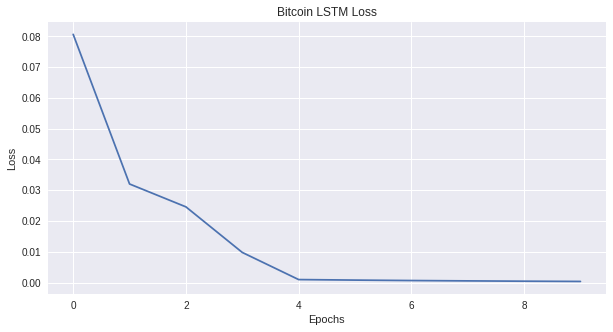

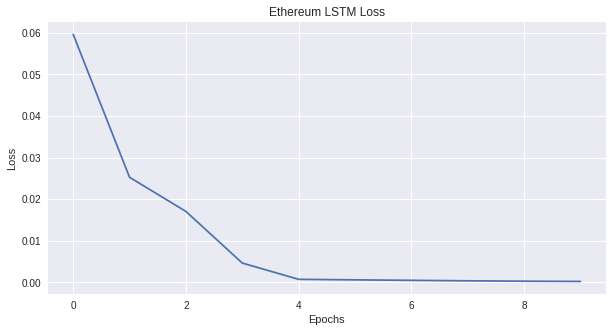

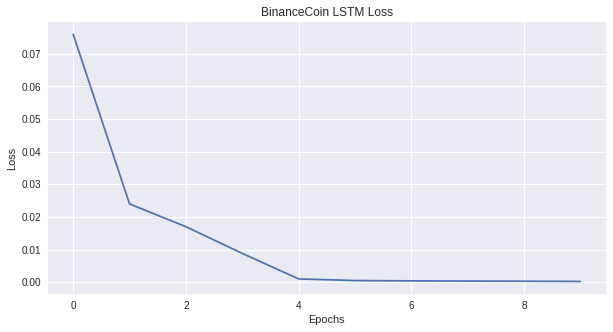

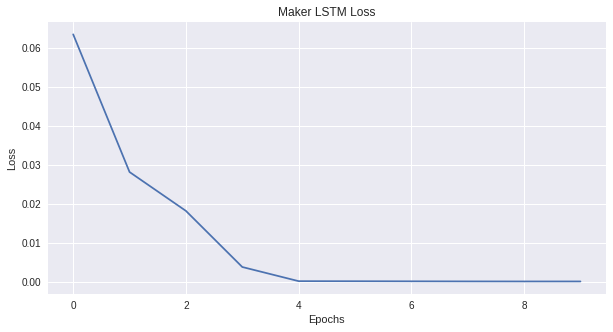

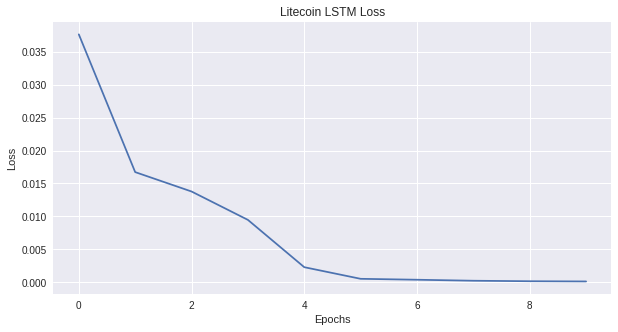

In [ ]:
LSTM_BTC.plotLoss(False)
LSTM_ETH.plotLoss(False)
LSTM_BNB.plotLoss(False)
LSTM_MKR.plotLoss(False)
LSTM_LTC.plotLoss(False)

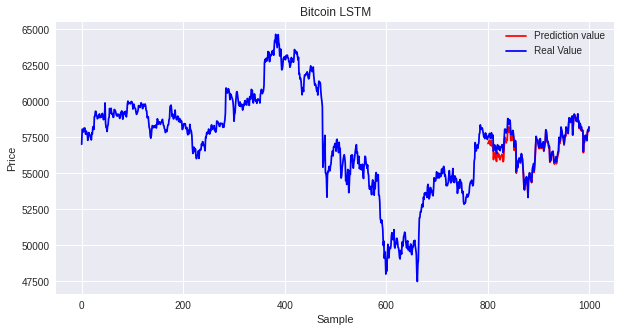

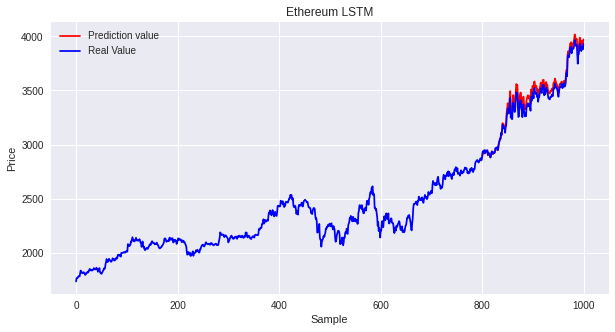

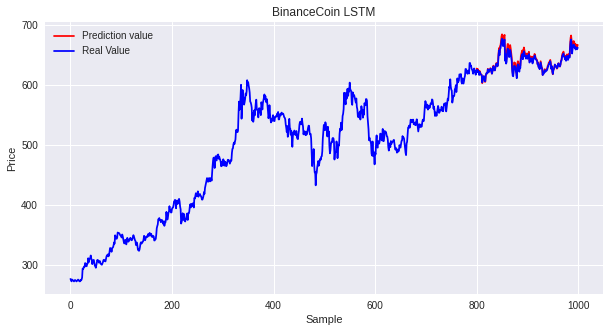

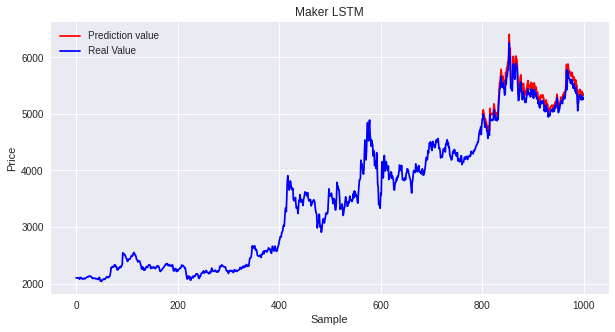

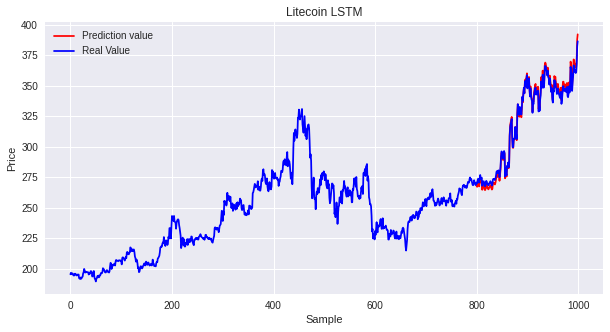

In [ ]:
plotPredictAndRealValue(Bitcoin_Y, Bitcoin_Pred_LSTM, 'Bitcoin', False, model = 'LSTM')
plotPredictAndRealValue(Ethereum_Y, Ethereum_Pred_LSTM, 'Ethereum', False, model = 'LSTM')
plotPredictAndRealValue(BinanceCoin_Y, BinanceCoin_Pred_LSTM, 'BinanceCoin', False, model = 'LSTM')
plotPredictAndRealValue(Maker_Y, Maker_Pred_LSTM, 'Maker', False, model = 'LSTM')
plotPredictAndRealValue(Litecoin_Y, Litecoin_Pred_LSTM, 'Litecoin', False, model = 'LSTM')

##### **Mean Absolute Error**

In [ ]:
from sklearn.metrics import *

print('MAE Bitcoin Linear Regression: ', mean_absolute_error(BTC_ytest, Bitcoin_Pred))
print('MAE Ethereum Linear Regression: ', mean_absolute_error(ETH_ytest, Ethereum_Pred))
print('MAE BinanceCoin Linear Regression: ', mean_absolute_error(BNB_ytest, BinanceCoin_Pred))
print('MAE Maker Linear Regression: ', mean_absolute_error(MKR_ytest, Maker_Pred))
print('MAE Litecoin Linear Regression: ', mean_absolute_error(LTC_ytest, Litecoin_Pred))
print()
print('MAE Bitcoin LSTM: ', mean_absolute_error(BTC_ytest, Bitcoin_Pred_LSTM))
print('MAE Ethereum LSTM: ', mean_absolute_error(ETH_ytest, Ethereum_Pred_LSTM))
print('MAE BinanceCoin LSTM: ', mean_absolute_error(BNB_ytest, BinanceCoin_Pred_LSTM))
print('MAE Maker LSTM: ', mean_absolute_error(MKR_ytest, Maker_Pred_LSTM))
print('MAE Litecoin LSTM: ', mean_absolute_error(LTC_ytest, Litecoin_Pred_LSTM))

MAE Bitcoin Linear Regression:  213.7983275248263
MAE Ethereum Linear Regression:  185.03247745273845
MAE BinanceCoin Linear Regression:  25.856158823114246
MAE Maker Linear Regression:  168.8230478928178
MAE Litecoin Linear Regression:  17.398844100149958

MAE Bitcoin LSTM:  191.34089376782242
MAE Ethereum LSTM:  41.841454510886685
MAE BinanceCoin LSTM:  2.887777135178685
MAE Maker LSTM:  106.13342420956488
MAE Litecoin LSTM:  2.4452675934996235
